# WIP: Diabetes Dataset Analysis 

In [11]:
%matplotlib inline
import pandas as pd
from pandas.plotting import scatter_matrix
import pandas_profiling
import matplotlib.pyplot as plt
from sklearn import datasets

In [2]:
dataset = datasets.load_diabetes()

What attributes does the object have:

In [12]:
dir(dataset)

['DESCR', 'data', 'feature_names', 'target']

Standard attributes for a scikit dataset. Let’s see what the notes on the dataset are:

In [3]:
print(dataset.DESCR)

Diabetes dataset

Notes
-----

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

Data Set Characteristics:

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attributes:
    :Age:
    :Sex:
    :Body mass index:
    :Average blood pressure:
    :S1:
    :S2:
    :S3:
    :S4:
    :S5:
    :S6:

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Bradley Efron, Trevor Hastie, Iain Johnstone and Robert Tibshirani

To summarise the data:
- Only quantitative variables
- Data has been centred and scaled
- y is also quantitative
- six sereum measurements

In [6]:
dataset.feature_names

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

Convert the numpy matrix to a data frame object

In [3]:
df = pd.DataFrame(
    data=dataset.data, 
    index=None, 
    columns=dataset.feature_names
)

Add the target column:

In [4]:
df['y'] = dataset.target

In [5]:
df.head(n=5)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,y
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


Interestingly, `sex` is not binary but takes floating point values. 

What does the profile of the data look like:

In [6]:
pf = pandas_profiling.ProfileReport(df)

In [7]:
pf

Number of variables,11
Number of observations,442
Total Missing (%),0.0%
Total size in memory,38.0 KiB
Average record size in memory,88.1 B
Numeric,10
Categorical,0
Boolean,1
Date,0
Text (Unique),0
Rejected,0


Now that we have some overall statistics for the data, what does the data look like when all columns are plotted against each other?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x25C7A4F0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x284094B0>]], dtype=object)

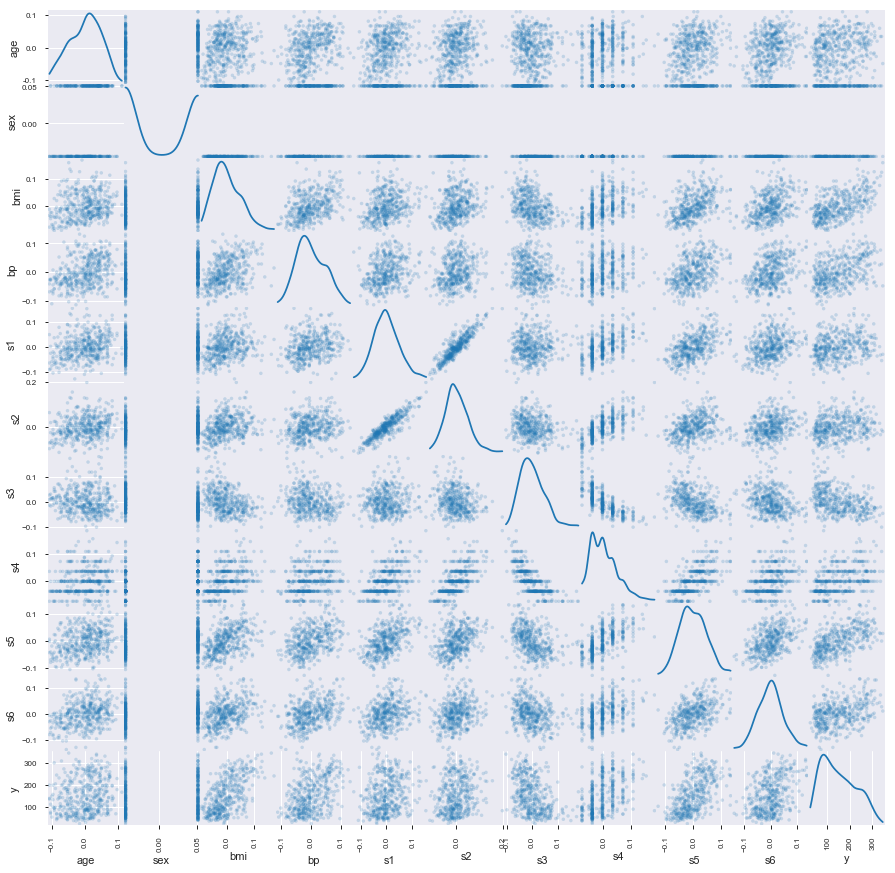

In [17]:
scatter_matrix(df, alpha=0.2, figsize=(15, 15), diagonal='kde')

`Sex` unsurprisingly falls onto one of two values, but the interesting feature here is `s4` which has a banding effect. The feature `s3` is the only feature negatively correlated with the other features, especially with `s4`

Let's see if there is any visual separation of the data by `sex`

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x28CD5850>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x2AB020D0>]], dtype=object)

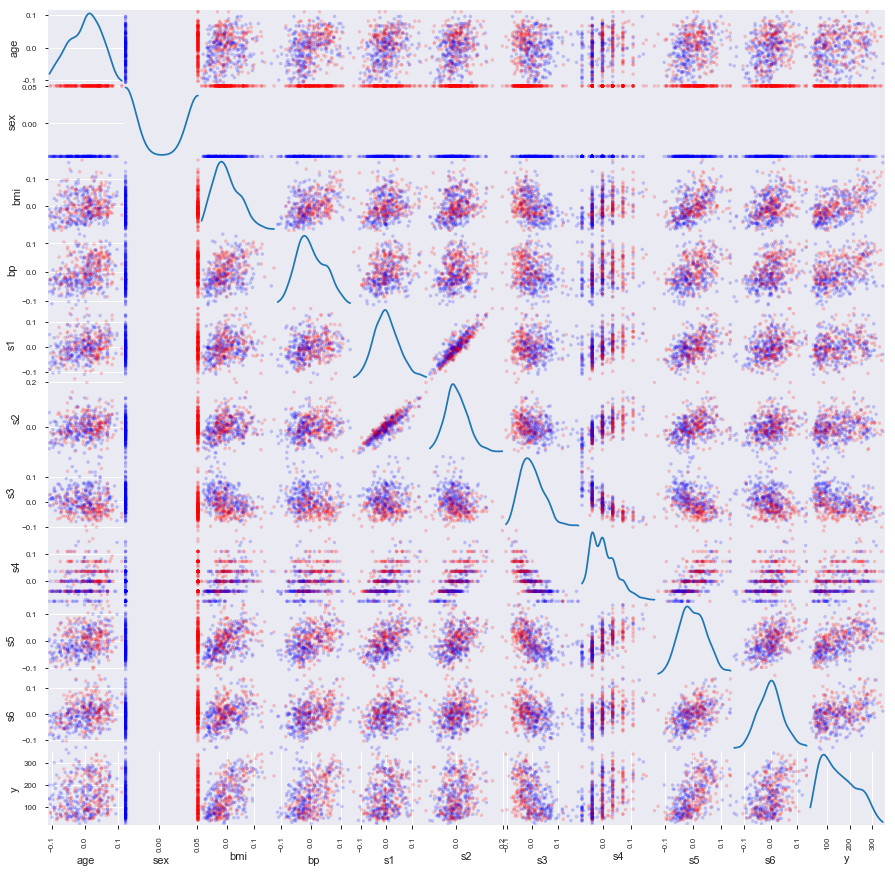

In [18]:
colours = ['red' if i > 0 else 'blue' for i in df['sex']]
scatter_matrix(df, alpha=0.2, figsize=(15, 15), diagonal='kde', color=colours)

Not really any visual separation by gender

## Lasso Regression

In [41]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1, fit_intercept=False)
lasso_reg.fit(dataset.data, dataset.target)

Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [42]:
lasso_reg.coef_

array([  -0.        , -155.36288234,  517.18201661,  275.08235083,
        -52.54026923,   -0.        , -210.15975349,    0.        ,
        483.91440913,   33.67282148])

In [36]:
from sklearn.linear_model import lasso_path, enet_path
from itertools import cycle
import numpy as np

In [37]:
alphas_lasso, coefs_lasso, _ = lasso_path(dataset.data, dataset.target, fit_intercept=False)

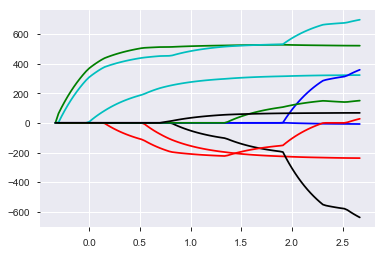

In [39]:
plt.figure(1)
ax = plt.gca()

colors = cycle(['b', 'r', 'g', 'c', 'k'])
neg_log_alphas_lasso = -np.log10(alphas_lasso)
for coef_l, c in zip(coefs_lasso, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)

Lasso coefs not mathching that in `lasso_reg.coef_`

In [73]:
#X = 1. / (np.arange(1, 11) + np.arange(0, 10)[:, np.newaxis])
#y = np.ones(10)

n_alphas = 200
alphas = np.logspace(-5, 1, n_alphas)
#alphas = np.linspace(-100, 100, 200)

coefs = []
for a in alphas:
    lasso_reg_vary_alpha = Lasso(alpha=a, fit_intercept=False)
    lasso_reg_vary_alpha.fit(dataset.data, dataset.target)
    coefs.append(lasso_reg_vary_alpha.coef_)

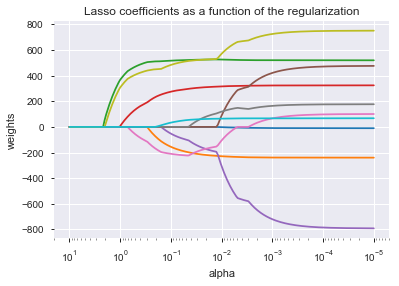

In [74]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

Higher alpha, more constrained the weights are